In [26]:
import netCDF4 as nc
import pandas as pd
from datetime import datetime
from scipy.constants import Boltzmann
from scipy import log

In [2]:
def get_dataframe_from_nc_file(nc_file_path):
    ds = nc.Dataset(nc_file_path)
    longitude = ds['longitude'][:]
    latitude = ds['latitude'][:]
    level = ds['level'][:]
    time = ds['time']
    time_convert = nc.num2date(time[:], time.units, time.calendar)[:]
    t = ds['t'][:]
    
    rows = []
    for time_i, a in enumerate(t):
        for level_i, b in enumerate(a):
            for lat_i, c in enumerate(b):
                for lon_i, d in enumerate(c):
                    rows.append({
                        'Latitude': latitude[lat_i],
                        'Longitude': longitude[lon_i],
                        'Time': time_convert[time_i],
                        'PressureLevel': level[level_i],
                        'Temperature': d
                    })
    df = pd.DataFrame(rows)
    df.to_csv(f'{nc_file_path[:-3]}.csv')
    return df
    

In [3]:
def get_average_temperature_of_a_day(df):
    df['date_only'] = df.apply(lambda x: datetime.strptime(str(x['Time']),'%Y-%m-%d %H:%M:%S').date(), axis=1)
    df = df.groupby(['date_only', 'PressureLevel'], as_index=False)['Temperature'].mean()
    return df

In [27]:
def convert_pressure_to_altitude(p_level, temp):
    K = Boltzmann
    m = 28.97
    g = 9.8
    P0 = 1013
    P = p_level * 100
    
    H = K * temp / (m * g) 
    Z = H * log(P0/P)
    return Z
    

In [4]:
dfs = []
nc_file_list = ['2021_jan2apr.nc', '2021_sep2dec.nc']

for file in nc_file_list:
    df = get_dataframe_from_nc_file(file)
    df = get_average_temperature_of_a_day(df)
    dfs.append(df)

In [5]:
final_df = pd.concat(dfs).reset_index(drop=True)

In [28]:
final_df['Day'] = final_df.apply(lambda x: x['date_only'].timetuple().tm_yday, axis=1)
final_df['Month'] = final_df.apply(lambda x: x['date_only'].month, axis=1)
final_df['Height'] = final_df.apply(lambda x: convert_pressure_to_altitude(x['PressureLevel'], x['Temperature']), axis=1)

/home/lenovo/miniconda3/envs/manisha/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  if __name__ == '__main__':


In [29]:
final_df

,date_only,PressureLevel,Temperature,Day,Month,Height
0,2021-01-01,1,253.939596,1,1,2.859461e-23
1,2021-01-01,2,248.117071,1,1,1.957542e-23
2,2021-01-01,3,240.647872,1,1,1.424104e-23
3,2021-01-01,5,231.591278,1,1,7.951968e-24
4,2021-01-01,7,228.517443,1,1,4.107236e-24
...,...,...,...,...,...,...
8949,2021-12-31,900,284.619778,365,12,-6.210400e-23
8950,2021-12-31,925,286.311245,365,12,-6.285456e-23
8951,2021-12-31,950,287.664449,365,12,-6.352470e-23
8952,2021-12-31,975,289.215775,365,12,-6.423262e-23


In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

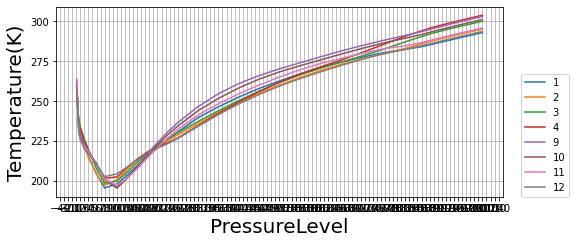

In [25]:
fig,ax = plt.subplots(1, figsize=(8,3.5))

month_df = final_df.groupby(['Month','PressureLevel'], as_index=False)['Temperature'].mean()
group_month = month_df.groupby(['Month'])

for month, df in group_month:
    heights = df["PressureLevel"].values
    avg_temp = df["Temperature"].values
    ax.plot(heights, avg_temp, label=month)
    
ax.set_xlabel("PressureLevel", fontsize=20)
ax.set_ylabel("Temperature(K)", fontsize=20)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.grid()
plt.legend(loc=(1.04,0))
plt.savefig('./output/month_wise_line_plot_netcdf.pdf')
plt.show()